In [2]:
import pyspark
from pyspark.sql import SparkSession

#Starting Spark Session
spark = SparkSession.builder.getOrCreate()



In [2]:
#Getting Borough data
borough_data = spark.read.csv('data/taxi _zone_lookup.csv', header=True)
#borough_data.show()


In [3]:
import pyspark.sql.functions as F
from pyspark.sql.types import *

#Get yellow taxis trip data from 2020
taxis_trips = spark.read.csv('data/tripdata/', header=True)

def get_month(value):
  return value.split("-")[1]
    
    
#Convert to a UDF Function (parameters: the function and its return type)
udf_get_month = F.udf(get_month, StringType())

#Add Month column to the dataset
trips = taxis_trips.withColumn("Month", udf_get_month("tpep_pickup_datetime"))

#trips.show()

In [4]:
#Join trip info with borough data
borough_trips = trips.join(borough_data, trips.PULocationID == borough_data.LocationID)
borough_trips.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----+----------+---------+--------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Month|LocationID|  Borough|                Zone|service_zone|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----+----------+---------+--------------------+------------+
|       1| 2020-11-01 00:37:37|  2020-11

# Período do ano em que os táxis são mais utilizados
## Critério: número de viagens

In [5]:
#Group the dataset by month, count the records and order by the count column
borough_trips.groupBy("Month").count().orderBy("count").show()

+-----+-------+
|Month|  count|
+-----+-------+
|   04| 237886|
|   05| 348370|
|   06| 549779|
|   07| 800430|
|   08|1007282|
|   09|1340892|
|   12|1462074|
|   11|1508900|
|   10|1681266|
|   03|3006942|
|   02|6299480|
|   01|6405198|
+-----+-------+



### Os táxis são mais utilizados em janeiro (6405198 viagens)

## Critério: quantidade de passageiros

In [5]:
#Casting passenger_count to Integer, since it is string
new_df = borough_trips.withColumn("passenger_count", borough_trips.passenger_count.cast(IntegerType()))

#Grouping by month and summing the number os passengers
new_df.groupBy("Month").agg(F.sum('passenger_count').alias('Passengers')).orderBy("Passengers").show()

+-----+----------+
|Month|Passengers|
+-----+----------+
|   04|    283231|
|   05|    380451|
|   06|    676814|
|   07|   1016698|
|   08|   1317999|
|   09|   1775148|
|   12|   1934072|
|   11|   1995476|
|   10|   2247303|
|   03|   4357543|
|   02|   9403624|
|   01|   9606865|
+-----+----------+



### O mês de janeiro é o que tem mais passageiros: 9606865

## Bairros com maior uso de táxis

### Premissa: o local em que foi solicitado o táxi (PULocation) foi utilizado para cálculo do uso de táxi

In [9]:
trips_count_by_borough = new_df.groupBy("Month", "Borough").count()
trips_count_by_borough.show()

+-----+-------------+-------+
|Month|      Borough|  count|
+-----+-------------+-------+
|   11|Staten Island|    369|
|   01|      Unknown|  47122|
|   05|     Brooklyn|  18714|
|   01|     Brooklyn|  71169|
|   04|          EWR|      9|
|   05|    Manhattan| 294100|
|   08|          EWR|     65|
|   09|    Manhattan|1216229|
|   07|    Manhattan| 708124|
|   03|    Manhattan|2754116|
|   11|        Bronx|  13367|
|   04|     Brooklyn|   7225|
|   09|Staten Island|    253|
|   10|    Manhattan|1540377|
|   08|Staten Island|    201|
|   09|       Queens|  60695|
|   11|    Manhattan|1381615|
|   12|       Queens|  63163|
|   05|       Queens|  20023|
|   12|    Manhattan|1334216|
+-----+-------------+-------+
only showing top 20 rows



In [8]:
#rightdf = trips_count_by_borough.groupBy("Month").agg(F.max("count").alias("count"))
#rightdf.show()
#res = trips_count_by_borough.join(rightdf, on="count", how="leftsemi")
#res.show()

In [10]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

windowMonth = Window.partitionBy("Month").orderBy(col("count").desc())

borough_top_n = trips_count_by_borough.withColumn("row",row_number().over(windowMonth)) \
  .filter(col("row") <= 4) 


In [8]:
borough_top_n.show()


+-----+---------+-------+---+
|Month|  Borough|  count|row|
+-----+---------+-------+---+
|   07|Manhattan| 708124|  1|
|   07|   Queens|  46897|  2|
|   07| Brooklyn|  23927|  3|
|   07|    Bronx|  13145|  4|
|   11|Manhattan|1381615|  1|
|   11|   Queens|  62912|  2|
|   11| Brooklyn|  29885|  3|
|   11|  Unknown|  20677|  4|
|   01|Manhattan|5846259|  1|
|   01|   Queens| 425465|  2|
|   01| Brooklyn|  71169|  3|
|   01|  Unknown|  47122|  4|
|   09|Manhattan|1216229|  1|
|   09|   Queens|  60695|  2|
|   09| Brooklyn|  29660|  3|
|   09|  Unknown|  20044|  4|
|   05|Manhattan| 294100|  1|
|   05|   Queens|  20023|  2|
|   05| Brooklyn|  18714|  3|
|   05|    Bronx|  11794|  4|
+-----+---------+-------+---+
only showing top 20 rows



In [12]:
#import matplotlib as plt
#temp = borough_top_n.select("count", "month").toPandas()
#temp.plot()
#display(plt.show())

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

borough_top_n = borough_top_n.orderBy("Month")
df = borough_top_n.toPandas()
df
#df.drop('row', inplace=True, axis=1)

,Month,Borough,count,row
0,01,Manhattan,5846259,1
1,01,Queens,425465,2
2,01,Brooklyn,71169,3
3,01,Unknown,47122,4
4,02,Manhattan,5797961,1
5,02,Queens,377976,2
6,02,Brooklyn,67972,3
7,02,Unknown,43405,4
8,03,Manhattan,2754116,1
9,03,Queens,182140,2


In [ ]:

df2 = df.drop('row', inplace=False, axis=1)
print(df2)

stack_selection = df2.groupby(["Month", "Borough"]).count().unstack()
stack_selection.columns = stack_selection.columns.droplevel()
stack_selection.plot(kind='bar', stacked=True)

In [ ]:
top1 = df[df.row == 1]
top2 = df[df.row == 2]

#ax=top1.plot(kind='line', x='Month', y='Taxi use',label='Top 1')      
#top2.plot(kind='line', x='Month', y='Taxi use', label='Top 2', ax=ax)

#patches, labels = ax.get_legend_handles_labels()
#ax.legend(patches, labels, loc='upper left', scatterpoints=1)

## Bairros com maior uso de táxi por mês
### Top 1: Manhattan
### Top 2: Queens
### Top 3: Brooklyn
### Top 4: Unknown / Bronx


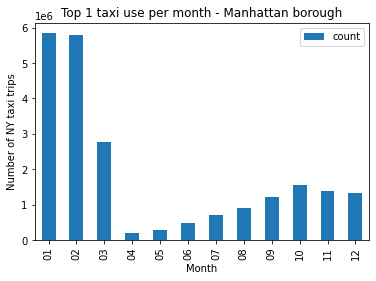

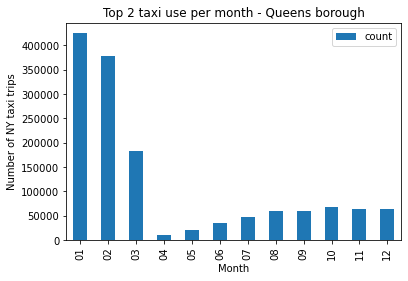

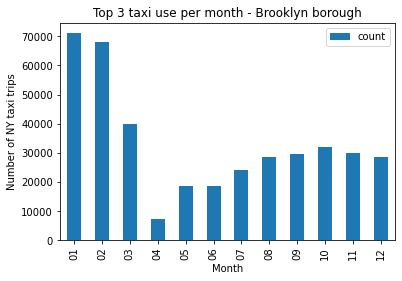

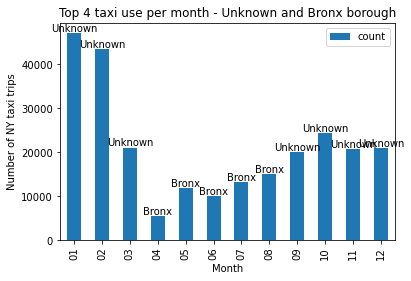

In [9]:
import matplotlib.pyplot as plt
import pandas as pd


#Get top, 2, 3 and 4 Boroughs which use taxis the most
top1 = df[df.row == 1]
top2 = df[df.row == 2]
top3 = df[df.row == 3]
top4 = df[df.row == 4]


def set_labels_title(ax, number, borough=""):
    title = "Top " + str(number) + " taxi use per month - " + borough + " borough"
    ax.set_ylabel('Number of NY taxi trips')  # Add a y-label to the axes.
    ax.set_title(title)  # Add a title to the axes.

ax = top1.plot(kind='bar',x='Month', y='count')
set_labels_title(ax, 1, "Manhattan")

ax = top2.plot(kind='bar',x='Month', y='count')
set_labels_title(ax, 2, "Queens")

ax = top3.plot(kind='bar',x='Month', y='count')
set_labels_title(ax, 3, "Brooklyn")

ax = top4.plot(kind='bar',x='Month', y='count')
set_labels_title(ax, 4, "Unknown and Bronx")

rects = ax.patches
y_labels = top4["Borough"].tolist()

for rect, label in zip(rects, y_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

    

## Janelas de tempo - viagens com mais passageiros

In [6]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

windowSpec  = Window.partitionBy("Borough").orderBy(col("passenger_count").desc())
start_end_times_df = new_df.select(col("tpep_pickup_datetime").cast("timestamp"), \
                                   col("tpep_dropoff_datetime").cast("timestamp"), \
                                   col("Borough"),col("passenger_count"))

   
#Convert to a UDF Function (parameters: the function and its return type)
udf_hour = F.udf(lambda x: x.hour, IntegerType())

#Add start_time and end_time columns to the dataframe
start_end_times_df = start_end_times_df.withColumn("start_hour", udf_hour("tpep_pickup_datetime"))
start_end_times_df = start_end_times_df.withColumn("end_hour", udf_hour("tpep_dropoff_datetime"))
start_end_times_df.show()


#start_end_times_df = start_end_times_df.withColumn("row_number",row_number().over(windowSpec)).show(truncate=False)


+--------------------+---------------------+---------+---------------+----------+--------+
|tpep_pickup_datetime|tpep_dropoff_datetime|  Borough|passenger_count|start_hour|end_hour|
+--------------------+---------------------+---------+---------------+----------+--------+
| 2020-11-01 00:37:37|  2020-11-01 00:51:45|Manhattan|              1|         0|       0|
| 2020-11-01 00:17:41|  2020-11-01 00:32:22|Manhattan|              2|         0|       0|
| 2020-11-01 00:42:29|  2020-11-01 01:09:08|Manhattan|              2|         0|       1|
| 2020-11-01 00:28:59|  2020-11-02 00:00:00|   Queens|              1|         0|       0|
| 2020-11-01 00:13:26|  2020-11-01 00:22:59|Manhattan|              1|         0|       0|
| 2020-11-01 00:09:36|  2020-11-01 00:20:55|Manhattan|              1|         0|       0|
| 2020-10-31 23:57:50|  2020-11-01 00:28:08|   Queens|              1|        23|       0|
| 2020-11-01 00:32:28|  2020-11-01 00:47:34|Manhattan|              1|         0|       0|

In [4]:
import pyspark.sql.functions as F

#Sum test with nullable data
simpleData = (("John", "Sales", None), \
    ("Tomas", "Sales", 4),  \
    ("Maria", "Finance", 3),  \
    ("Paulo", "Finance", None))
 
columns= ["employee_name", "department", "salary"]
test_example = spark.createDataFrame(data = simpleData, schema = columns)
test_example.printSchema()
test_example.agg(F.sum("salary")).show()



root
 |-- employee_name: string (nullable = true)
 |-- department: string (nullable = true)
 |-- salary: long (nullable = true)

+-----------+
|sum(salary)|
+-----------+
|          7|
+-----------+

